## Importing required libraries

In [ ]:
from __future__ import print_function
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import pandas as pd


## Data loader and transformations


In [ ]:
# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train_data, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test_data, **dataloader_args)

# specify the image classes
classes = train_data.classes
print("Unique classes of images are:", classes)


100%|██████████| 170498071/170498071 [00:02<00:00, 60266857.14it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
CUDA Available? True
Unique classes of images are: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Plotting images from the dataset

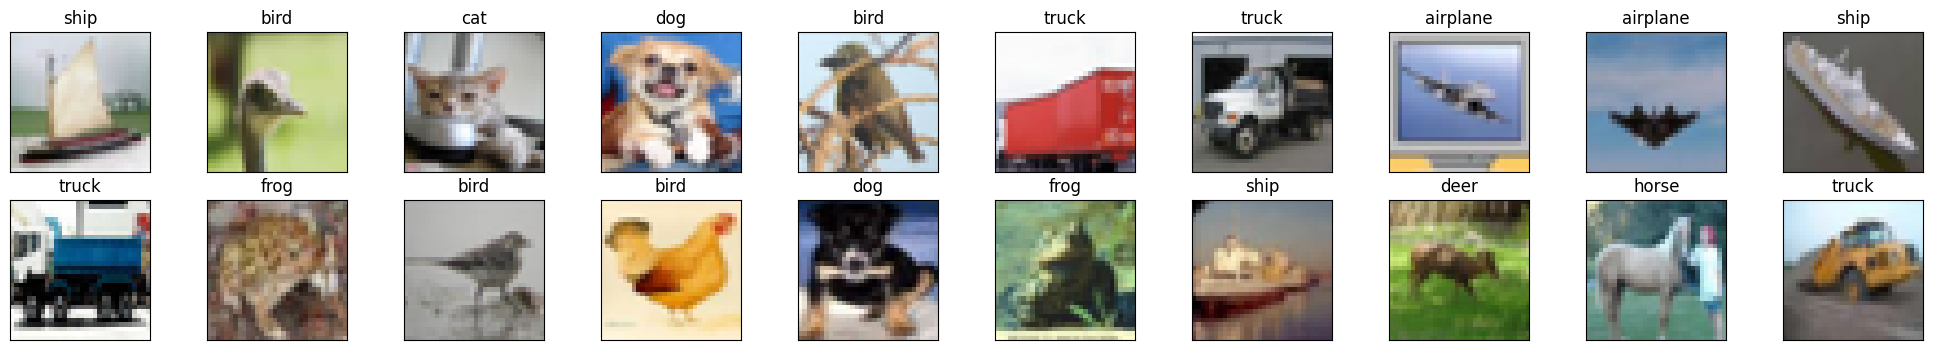

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

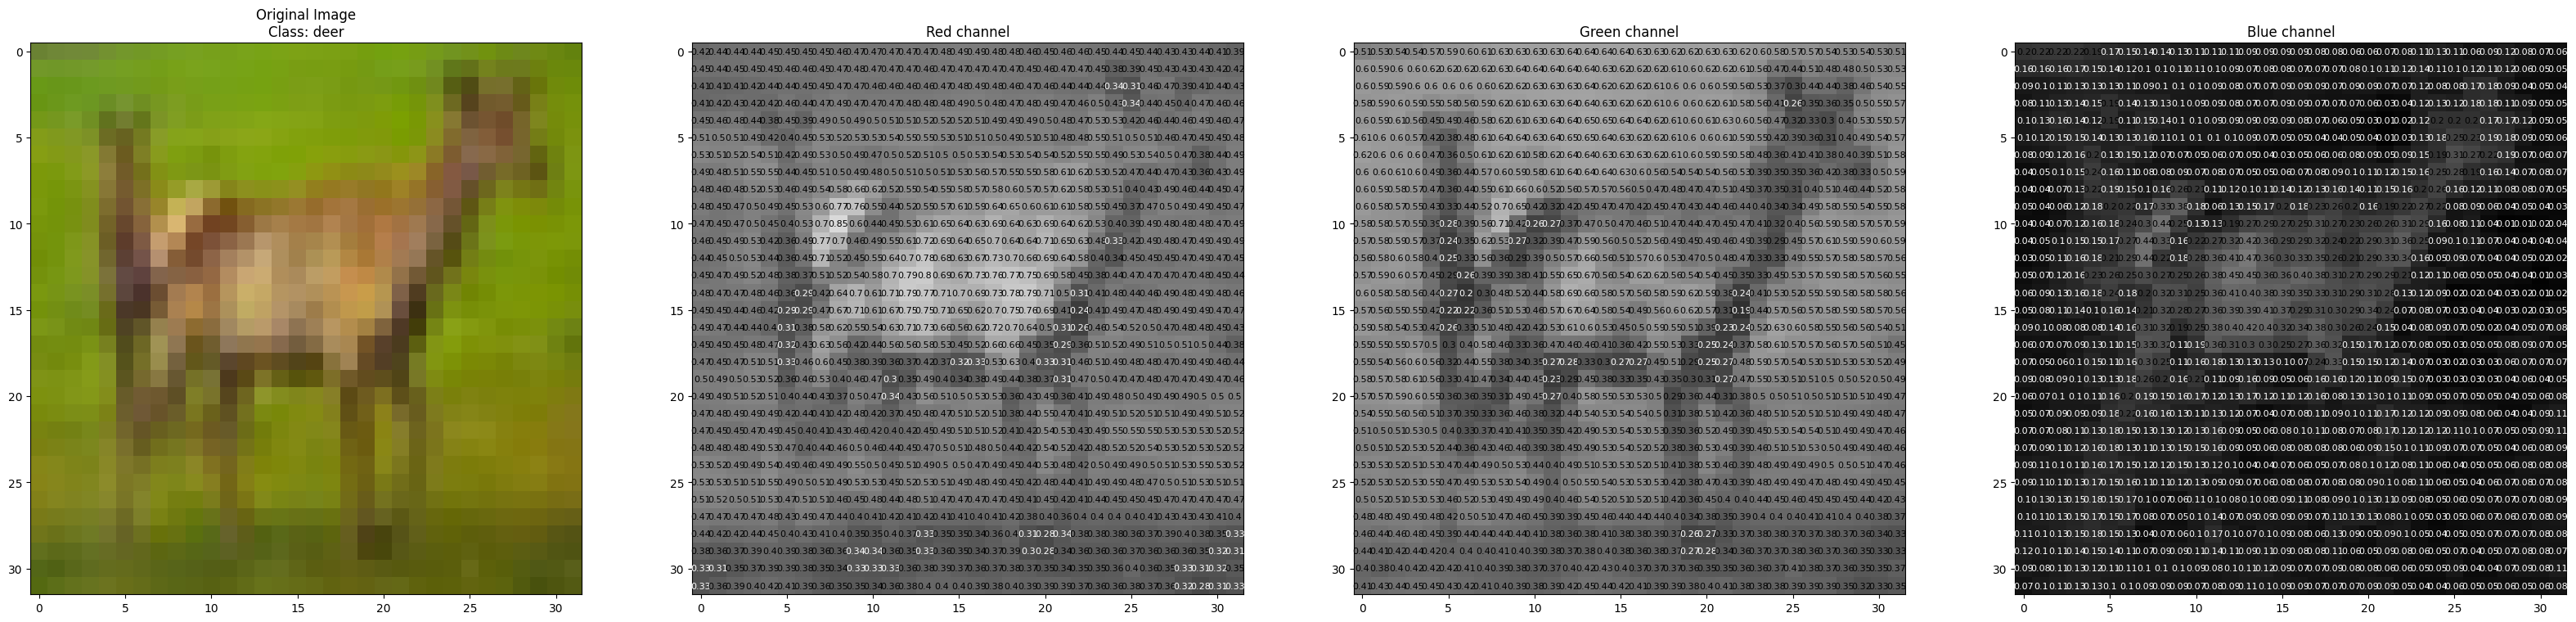

In [ ]:
# Obtain one batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy() # Convert images to numpy for display

# Original image
original_img = np.squeeze(images[3])
image_class = classes[labels[3]]  # Get the class name for the image

# Normalize original image
normalized_img = (original_img.transpose(1, 2, 0) + 1) / 2  # Normalize image to [0, 1] range

# RGB channels
rgb_img = np.transpose(normalized_img, (0, 1, 2))
channels = ['Red channel', 'Green channel', 'Blue channel']

fig = plt.figure(figsize=(40, 12))

# Display original image
ax_original = fig.add_subplot(1, 4, 1)
ax_original.imshow(normalized_img)
ax_original.set_title(f"Original Image\nClass: {image_class}")  # Add class label to the title

# Display RGB channels
for idx in range(rgb_img.shape[2]):
    ax = fig.add_subplot(1, 4, idx + 2)
    img = rgb_img[:, :, idx]
    ax.imshow(img, cmap='gray', vmin=0, vmax=1)  # Specify vmin and vmax to ensure correct range
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max() / 2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y], 2) if img[x][y] != 0 else 0
            ax.annotate(
                str(val),
                xy=(y, x),
                horizontalalignment='center',
                verticalalignment='center',
                size=8,
                color='white' if img[x][y] < thresh else 'black'
            )

plt.show()

## Selecting device as CUDA/CPU based on availability

In [ ]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda


## Defining Model

In [ ]:
dropout_value = 0.1

class Net(nn.Module):
    def __init__(self, use_batch_norm=False, use_layer_norm=False, use_group_norm=False, num_groups=2):
        super(Net, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.use_layer_norm = use_layer_norm
        self.use_group_norm = use_group_norm
        self.num_groups = num_groups

# ***************** BATCH NORMALIZAION ############################
        if self.use_batch_norm:
          # Input Block
          self.convblock1 = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.BatchNorm2d(10),
              nn.Dropout(dropout_value)
          ) # output_size = 30, RF=3

          # CONVOLUTION BLOCK 1
          self.convblock2 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.BatchNorm2d(20),
              nn.Dropout(dropout_value)
          ) # output_size = 28, RF=5

          # TRANSITION BLOCK 1
          self.convblock3 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          ) # output_size = 28, RF=5
          self.pool1 = nn.MaxPool2d(2, 2) # output_size = 14, RF=6

          # CONVOLUTION BLOCK 2
          self.convblock4 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
              nn.ReLU(),
              nn.BatchNorm2d(20),
              nn.Dropout(dropout_value)
          ) # output_size = 14, RF=10
          self.convblock5 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3, 3), padding=1, bias=False),
              nn.ReLU(),
              nn.BatchNorm2d(30),
              nn.Dropout(dropout_value)
          ) # output_size = 14, RF=14
          self.convblock6 = nn.Sequential(
              nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(3, 3), padding=1, bias=False),
              nn.ReLU(),
              nn.BatchNorm2d(40),
              nn.Dropout(dropout_value)
          ) # output_size = 14, RF=18

          # TRANSITION BLOCK 2
          self.convblock7 = nn.Sequential(
              nn.Conv2d(in_channels=40, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          ) # output_size = 14, RF=18
          self.pool2 = nn.MaxPool2d(2, 2) # output_size = 7, RF=20

          # CONVOLUTION BLOCK 3
          self.convblock8 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.BatchNorm2d(20),
              nn.Dropout(dropout_value)
          ) # output_size = 5, RF=28
          self.convblock9 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.BatchNorm2d(30),
              nn.Dropout(dropout_value)
          ) # output_size = 3, RF=36
          self.convblock10 = nn.Sequential(
              nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.BatchNorm2d(40),
              nn.Dropout(dropout_value)
          ) # output_size = 1, RF=44

          # OUTPUT BLOCK
          self.gap = nn.Sequential(
              nn.AvgPool2d(kernel_size=1)
          ) # output_size = 1, RF=44

          self.convblock11 = nn.Sequential(
              nn.Conv2d(in_channels=40, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          ) # output_size = 1, RF=44


# ***************** LAYER NORMALIZAION ############################
        elif self.use_layer_norm:
          # Input Block
          self.convblock1 = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.GroupNorm(1, 10),
              nn.Dropout(dropout_value)
          )  # output_size = 30, RF=3

          # CONVOLUTION BLOCK 1
          self.convblock2 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.GroupNorm(1, 20),
              nn.Dropout(dropout_value)
          )  # output_size = 28, RF=5

          # TRANSITION BLOCK 1
          self.convblock3 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          )  # output_size = 28, RF=5
          self.pool1 = nn.MaxPool2d(2, 2)  # output_size = 14, RF=6

          # CONVOLUTION BLOCK 2
          self.convblock4 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
              nn.ReLU(),
              nn.GroupNorm(1, 20),
              nn.Dropout(dropout_value)
          )  # output_size = 14, RF=10
          self.convblock5 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3, 3), padding=1, bias=False),
              nn.ReLU(),
              nn.GroupNorm(1, 30),
              nn.Dropout(dropout_value)
          )  # output_size = 14, RF=14
          self.convblock6 = nn.Sequential(
              nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(3, 3), padding=1, bias=False),
              nn.ReLU(),
              nn.GroupNorm(1, 40),
              nn.Dropout(dropout_value)
          )  # output_size = 14, RF=18

          # TRANSITION BLOCK 2
          self.convblock7 = nn.Sequential(
              nn.Conv2d(in_channels=40, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          )  # output_size = 14, RF=18
          self.pool2 = nn.MaxPool2d(2, 2)  # output_size = 7, RF=20

          # CONVOLUTION BLOCK 3
          self.convblock8 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.GroupNorm(1, 20),
              nn.Dropout(dropout_value)
          )  # output_size = 5, RF=28
          self.convblock9 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.GroupNorm(1, 30),
              nn.Dropout(dropout_value)
          )  # output_size = 3, RF=36
          self.convblock10 = nn.Sequential(
              nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.GroupNorm(1, 40),
              nn.Dropout(dropout_value)
          )  # output_size = 1, RF=44

          # OUTPUT BLOCK
          self.gap = nn.Sequential(
              nn.AvgPool2d(kernel_size=1)
          )  # output_size = 1, RF=44

          self.convblock11 = nn.Sequential(
              nn.Conv2d(in_channels=40, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          )  # output_size = 1, RF=44



# ***************** GROUP NORMALIZAION ############################
        elif self.use_group_norm:
          # Input Block
          self.convblock1 = nn.Sequential(
              nn.Conv2d(in_channels=3, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.GroupNorm(self.num_groups, 10),
              nn.Dropout(dropout_value)
          )  # output_size = 30, RF=3

          # CONVOLUTION BLOCK 1
          self.convblock2 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.GroupNorm(self.num_groups, 20),
              nn.Dropout(dropout_value)
          )  # output_size = 28, RF=5

          # TRANSITION BLOCK 1
          self.convblock3 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          )  # output_size = 28, RF=5
          self.pool1 = nn.MaxPool2d(2, 2)  # output_size = 14, RF=6

          # CONVOLUTION BLOCK 2
          self.convblock4 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=1, bias=False),
              nn.ReLU(),
              nn.GroupNorm(self.num_groups, 20),
              nn.Dropout(dropout_value)
          )  # output_size = 14, RF=10
          self.convblock5 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3, 3), padding=1, bias=False),
              nn.ReLU(),
              nn.GroupNorm(self.num_groups, 30),
              nn.Dropout(dropout_value)
          )  # output_size = 14, RF=14
          self.convblock6 = nn.Sequential(
              nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(3, 3), padding=1, bias=False),
              nn.ReLU(),
              nn.GroupNorm(self.num_groups, 40),
              nn.Dropout(dropout_value)
          )  # output_size = 14, RF=18

          # TRANSITION BLOCK 2
          self.convblock7 = nn.Sequential(
              nn.Conv2d(in_channels=40, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          )  # output_size = 14, RF=18
          self.pool2 = nn.MaxPool2d(2, 2)  # output_size = 7, RF=20

          # CONVOLUTION BLOCK 3
          self.convblock8 = nn.Sequential(
              nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.GroupNorm(self.num_groups, 20),
              nn.Dropout(dropout_value)
          )  # output_size = 5, RF=28
          self.convblock9 = nn.Sequential(
              nn.Conv2d(in_channels=20, out_channels=30, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.GroupNorm(self.num_groups, 30),
              nn.Dropout(dropout_value)
          )  # output_size = 3, RF=36
          self.convblock10 = nn.Sequential(
              nn.Conv2d(in_channels=30, out_channels=40, kernel_size=(3, 3), padding=0, bias=False),
              nn.ReLU(),
              nn.GroupNorm(self.num_groups, 40),
              nn.Dropout(dropout_value)
          )  # output_size = 1, RF=44

          # OUTPUT BLOCK
          self.gap = nn.Sequential(
              nn.AvgPool2d(kernel_size=1)
          )  # output_size = 1, RF=44

          self.convblock11 = nn.Sequential(
              nn.Conv2d(in_channels=40, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
          )  # output_size = 1, RF=44


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.pool2(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.gap(x)
        x = self.convblock11(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

## Selecting model and printing model summary
The model can be used to apply batch, group and layer normalization.


*   For batch normalization, set the "use_batch_norm" flag to True
    ```
      model = Net(use_batch_norm=True).to(device)
    ```
*   For  group normalization, set the "use_group_norm" flag to True
    ```
    model = Net(use_group_norm=True, num_groups=2).to(device)
    ```
*   For layer normalization, set the "use_layer_norm" flag to True
    ```
    model = Net(use_layer_norm=True).to(device)
    ```




In [ ]:
# using batch norm
model = Net(use_batch_norm=True).to(device)

# Model Summary
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 30, 30]             270
              ReLU-2           [-1, 10, 30, 30]               0
       BatchNorm2d-3           [-1, 10, 30, 30]              20
           Dropout-4           [-1, 10, 30, 30]               0
            Conv2d-5           [-1, 20, 28, 28]           1,800
              ReLU-6           [-1, 20, 28, 28]               0
       BatchNorm2d-7           [-1, 20, 28, 28]              40
           Dropout-8           [-1, 20, 28, 28]               0
            Conv2d-9           [-1, 10, 28, 28]             200
        MaxPool2d-10           [-1, 10, 14, 14]               0
           Conv2d-11           [-1, 20, 14, 14]           1,800
             ReLU-12           [-1, 20, 14, 14]               0
      BatchNorm2d-13           [-1, 20, 14, 14]              40
          Dropout-14           [-1, 20,

## Defining Train and Test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []
train_loss = []
train_accuracy = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Batch_id={batch_idx}')
    train_acc.append(100*correct/processed)

  train_accuracy.append(train_acc[-1])
  train_loss.append([x.item() for x in train_losses][-1])


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_acc.append(100. * correct / len(test_loader.dataset))

## Defining the optimizer and number of epochs. Training and testing is carried out in the loop

In [ ]:

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    print("\n")

epoch_list = [ i+1 for i in range(EPOCHS)]
df = pd.DataFrame(epoch_list, columns=['epoch'])
train_loss = [round(i,2) for i in train_loss]
train_accuracy = [round(i,2) for i in train_accuracy]
test_loss = [round(i,2) for i in test_losses]
test_accuracy = [round(i,2) for i in test_acc]

df['train_loss'] = train_loss
df['train_accuracy'] = train_accuracy
df['test_loss'] = test_loss
df['test_accuracy'] = test_accuracy
df.style.hide(axis='index')


EPOCH: 1


Batch_id=390: 100%|██████████| 391/391 [00:26<00:00, 14.65it/s]




EPOCH: 2


Batch_id=390: 100%|██████████| 391/391 [00:18<00:00, 21.20it/s]




EPOCH: 3


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.82it/s]




EPOCH: 4


Batch_id=390: 100%|██████████| 391/391 [00:18<00:00, 21.27it/s]




EPOCH: 5


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.66it/s]




EPOCH: 6


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 21.98it/s]




EPOCH: 7


Batch_id=390: 100%|██████████| 391/391 [00:18<00:00, 20.69it/s]




EPOCH: 8


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.43it/s]




EPOCH: 9


Batch_id=390: 100%|██████████| 391/391 [00:18<00:00, 21.39it/s]




EPOCH: 10


Batch_id=390: 100%|██████████| 391/391 [00:18<00:00, 20.99it/s]




EPOCH: 11


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 21.81it/s]




EPOCH: 12


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.08it/s]




EPOCH: 13


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.39it/s]




EPOCH: 14


Batch_id=390: 100%|██████████| 391/391 [00:18<00:00, 20.73it/s]




EPOCH: 15


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.38it/s]




EPOCH: 16


Batch_id=390: 100%|██████████| 391/391 [00:18<00:00, 21.69it/s]




EPOCH: 17


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.51it/s]




EPOCH: 18


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.40it/s]




EPOCH: 19


Batch_id=390: 100%|██████████| 391/391 [00:18<00:00, 21.34it/s]




EPOCH: 20


Batch_id=390: 100%|██████████| 391/391 [00:17<00:00, 22.63it/s]


epoch,train_loss,train_accuracy,test_loss,test_accuracy
1,1.320000,38.020000,1.660000,38.970000
2,1.250000,50.400000,1.350000,51.010000
3,1.150000,55.970000,1.180000,57.540000
4,1.090000,60.130000,1.120000,59.950000
5,1.000000,62.570000,1.030000,63.070000
6,1.190000,64.570000,0.990000,64.710000
7,1.060000,65.970000,0.980000,65.440000
8,0.950000,67.240000,0.890000,68.680000
9,0.720000,68.840000,0.890000,68.420000
10,1.030000,69.590000,0.810000,71.530000


## Plotting the training/testing loss and accuracies

Text(0.5, 1.0, 'Test Accuracy')

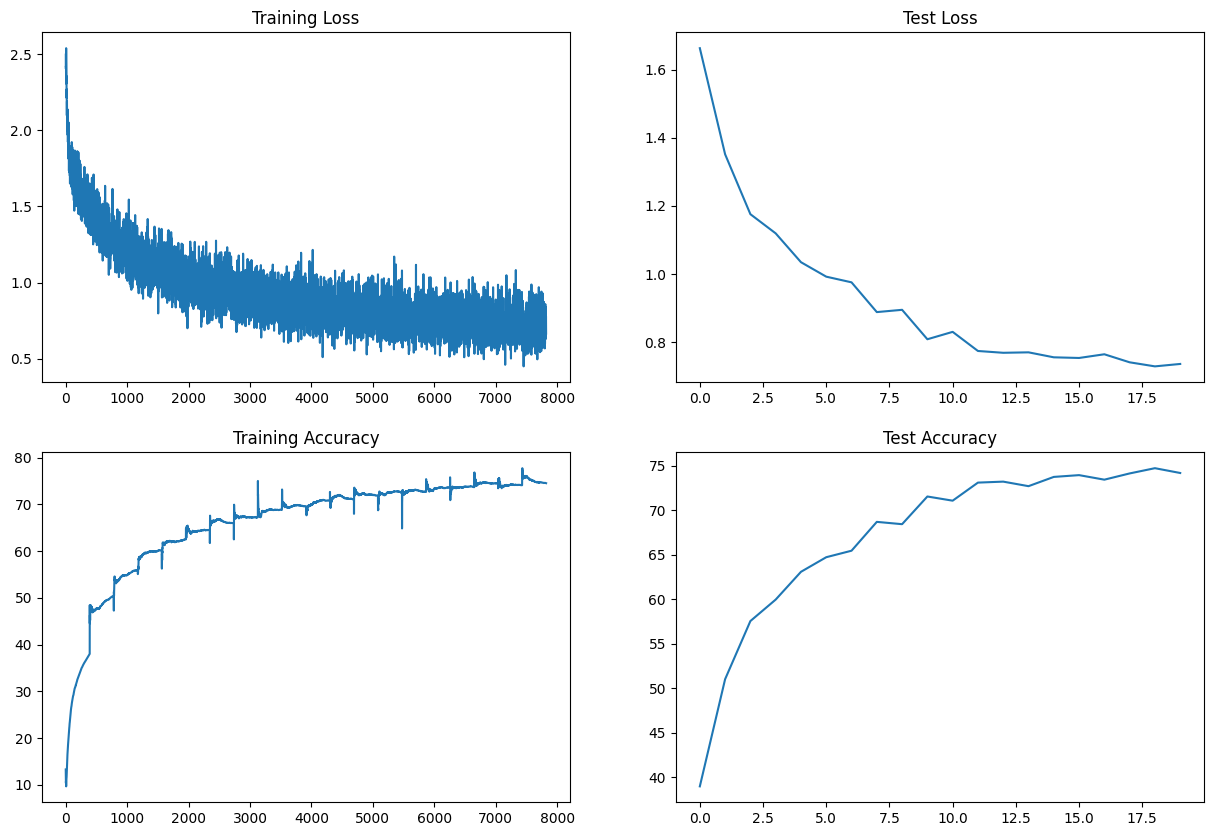

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
train_loss_array = [x.item() for x in train_losses]
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss_array)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

## Defining a function to display the misclassified images

Misclassified Images:


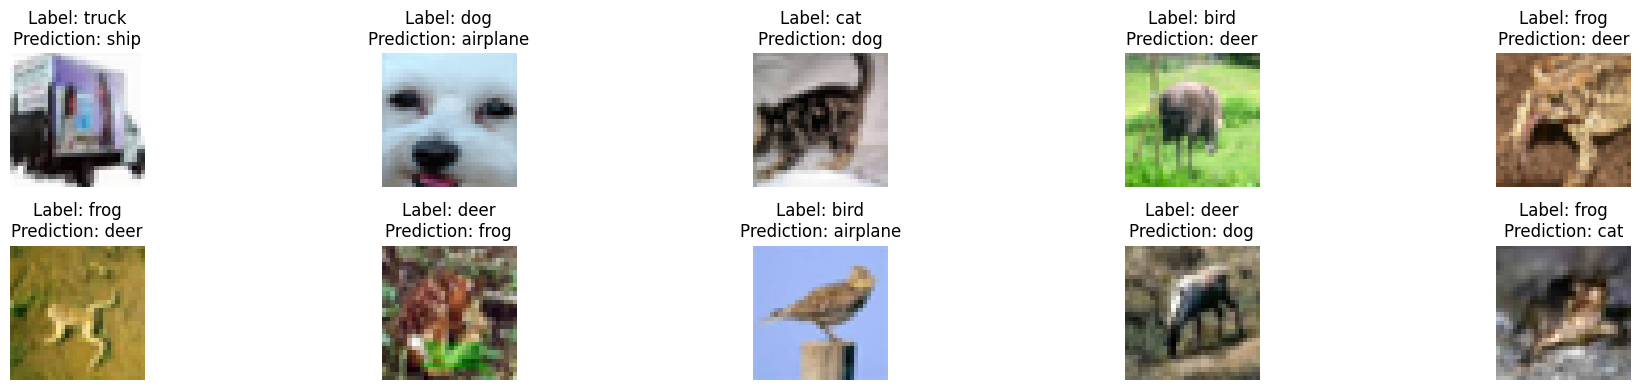

In [ ]:
import matplotlib.pyplot as plt

def test(model, device, test_loader):
    model.eval()
    misclassified_images = []
    misclassified_labels = []
    misclassified_predictions = []

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            # Check for misclassified images
            misclassified_mask = ~pred.eq(target.view_as(pred)).squeeze()
            misclassified_images.extend(data[misclassified_mask])
            misclassified_labels.extend(target.view_as(pred)[misclassified_mask])
            misclassified_predictions.extend(pred[misclassified_mask])

    return misclassified_images[:10], misclassified_labels[:10], misclassified_predictions[:10]

misclassified_images, misclassified_labels, misclassified_predictions = test(model, device, test_loader)

print("Misclassified Images:")
fig = plt.figure(figsize=(20, 4))
for i in range(len(misclassified_images)):
    ax = fig.add_subplot(2, 5, i + 1)
    image = misclassified_images[i].cpu().numpy().transpose(1, 2, 0)
    label = misclassified_labels[i].cpu().numpy().item()  # Convert to integer
    prediction = misclassified_predictions[i].cpu().numpy().item()  # Convert to integer
    # Normalize image data
    image = (image - np.min(image)) / (np.max(image) - np.min(image))
    ax.imshow(image)
    ax.set_title(f'Label: {classes[label]}\nPrediction: {classes[prediction]}')
    ax.axis('off')

plt.tight_layout()
plt.show()